# ARIMA Model Fitting and Prediction



## 1. Data generation

In [1]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import warnings
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter("ignore")


np.random.seed(506742)
ar = np.array([1, -0.5])
ma = np.array([1, 0.3])
process = ArmaProcess(ar, ma)
y = process.generate_sample(nsample=200)
y = np.cumsum(y)

y = pd.DataFrame(y, columns=["data"])

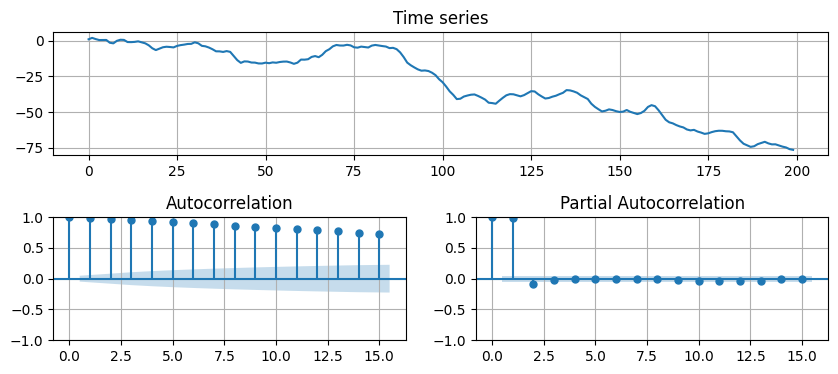

In [2]:
tsplot(y["data"])

No apparent seasonality is visible in the time series. However, the data exhibits a linear, decreasing trend, which strongly suggests that first-order differencing will be required to achieve stationarity.

The Partial Autocorrelation Function (PACF) initially suggests an Autoregressive process of order 1 (AR(1)). Crucially, the PACF value at a lag of 1 is close to 1, which further confirms the presence of a linear trend that the differencing operation aims to remove.

## 2. Modeling

Rules for ARIMA(p, d, q)

- $d \leq 2 \Rightarrow$ We rarely need the second differences.
- $p=0$ or $q=0$  $\Rightarrow$ We generally do not favor mixed models.
- $p+q \leq 3 \Rightarrow$ More complex models are rare.
- Coefficients $\phi_i$ close to $\theta_i$ may work against each other.
- Generally, we choose the simplest possible models.

 

While we initially expect a differencing order of d=1, we should avoid making a quick decision. To allow the auto_arima function to explore a wider range of possibilities, we will set d to None and let the algorithm determine the optimal differencing order.

We like $p=0$ or $q=0$ so we set start_p=0, and start_q=0. 

$p+q \leq 3$ can be inforced by max_order=3. 

If the best-fitting model determined by auto_arima reaches this limit, we can always increase max_order and rerun the optimization.




In [3]:
model_fit_auto_aic = pm.auto_arima(
    y,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=3,
    max_q=3,
    max_order=3,
    m=1,
    d=None,
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    information_criterion="aic",
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=666.107, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=570.508, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=558.627, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=554.512, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=560.117, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=553.505, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=555.503, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=553.558, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=555.495, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=555.551, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.509 seconds


In [4]:
model_fit_auto_bic = pm.auto_arima(
    y,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=3,
    max_q=3,
    max_order=3,
    m=1,
    d=None,
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    information_criterion="bic",
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=672.694, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=580.388, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=571.801, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=570.979, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=569.997, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=566.678, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=571.970, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=566.732, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=571.961, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=572.017, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.504 seconds


In [5]:
best_order_aic = model_fit_auto_aic.order
best_order_bic = model_fit_auto_bic.order

print(f"Optimal ARIMA Order based on AIC: {best_order_aic}")
print(f"Optimal ARIMA Order based on BIC: {best_order_bic}")

Optimal ARIMA Order based on AIC: (1, 1, 1)
Optimal ARIMA Order based on BIC: (1, 1, 1)


For the purpose of data explanation and favoring parsimony, we prioritize the model selected by the Bayesian Information Criterion (BIC), as it imposes a stronger penalty on model complexity than the Akaike Information Criterion (AIC). Since the auto_arima function identified the same optimal model using both the AIC and BIC metrics, the selection of the final model is straightforward.

In [6]:
best_model_by_bic = ARIMA(y, order=best_order_bic, trend="n")
result_by_bic = best_model_by_bic.fit()
print(result_by_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  200
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -275.051
Date:                Tue, 21 Oct 2025   AIC                            556.102
Time:                        20:31:10   BIC                            565.982
Sample:                             0   HQIC                           560.101
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5252      0.088      5.992      0.000       0.353       0.697
ma.L1          0.2909      0.105      2.767      0.006       0.085       0.497
sigma2         0.9258      0.097      9.533      0.0

The estimated coefficients for all model parameters (ar.L1, ma.L2, and σ2) are statistically significant, as we reject the null hypothesis (H0​) for each individual parameter's t-test.

Ljung-Box (Autocorrelation)
The null hypothesis (H0​) is that the residuals are independently distributed.
Since the P-value (0.16) is much greater than 0.05, you do not reject the null hypothesis.
It suggests there is no significant autocorrelation left in the residuals.


Jarque-Bera (Normality)
The null hypothesis (H0​) is that the residuals are normally distributed.
Since the P-value (0.95) is greater than 0.05, you do not reject the null hypothesis.
It indicates that the residuals are reasonably normally distributed.



Heteroskedasticity (Variance)
The null hypothesis (H0​) is that the residuals are NOT heteroscedastic (have constant variance).
Since the P-value (0.89) is greater than 0.05, you do not reject the null hypothesis.
It suggests the model's errors have constant variance over the observation period.


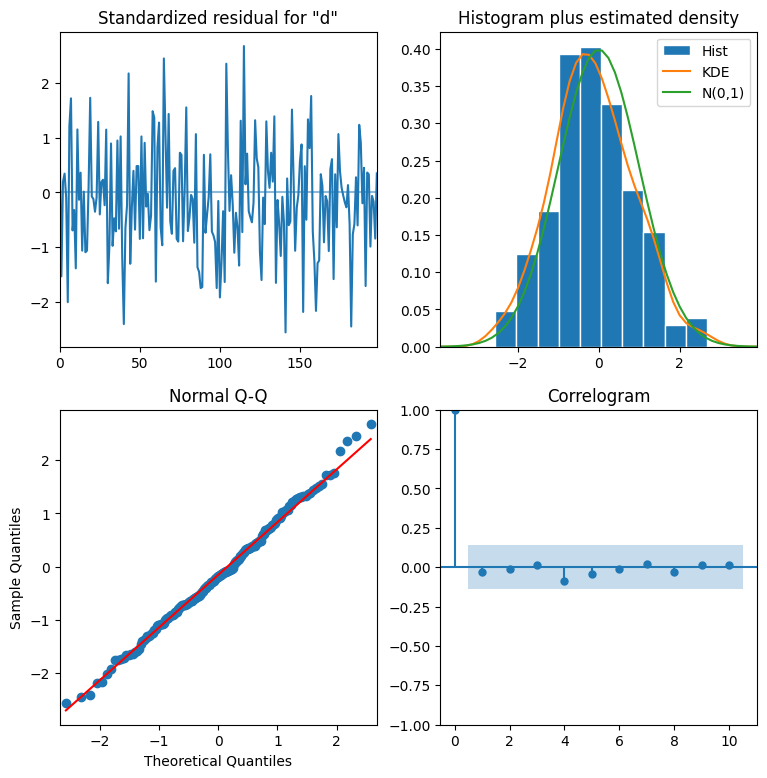

In [7]:
result_by_bic.plot_diagnostics(figsize=(9, 9))
plt.show()

Standardized Residuals (Top Left): The random scatter around zero, with no visible trends or changing variance, confirms the model has captured the data's structure and supports homoscedasticity (constant variance).

Histogram/Density (Top Right) & Normal Q-Q Plot (Bottom Left): The density curve closely follows the normal distribution, and the Q-Q plot points lie largely on the 45∘ line. This strongly confirms the normality assumption of the residuals.

Correlogram (Bottom Right): The absence of significant spikes confirms that no autocorrelation remains.

## 3. Validation

In the preceding steps, our focus was on in-sample fit, utilizing metrics such as the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These criteria assess how effectively the model explains the observed data while penalizing model complexity.

The next step in validation is evaluating the out-of-sample forecast accuracy. This is achieved using an empirical method, typically cross-validation with a rolling or sliding window, and is measured by metrics like the Root Mean Square Error (RMSE).

To comprehensively validate the previously selected model, we must compare its performance against alternative models using the RMSE metric. 

Out-of-sample performance will be assessed using a rolling window, where the ARIMA model is re-fitted iteratively for each forecast step.

In [ ]:
def calculate_rmse(df, order, initial_train_size=20, step=1):
    """
    Calculates the Root Mean Squared Error (RMSE) using a rolling-window approach 
    with an ARIMA model for time series forecasting.

    The function iteratively trains an ARIMA model on an expanding window of data
    and forecasts the next single step to calculate the error against the actual value.

    Args:
        df (pd.Series or pd.DataFrame): The time series data to be modeled and evaluated.
                                        It should contain the target variable.
        order (tuple): The (p, d, q) order of the ARIMA model.
        initial_train_size (int, optional): The initial size of the training window. 
                                            The first forecast starts at this index. Defaults to 20.
        step (int, optional): The number of steps the rolling window advances in each iteration. 
                              Determines the frequency of model retraining and error calculation. Defaults to 1.

    Returns:
        float: The calculated Root Mean Squared Error (RMSE) over the rolling forecasts.

    Notes:
        - The function uses the `statsmodels.tsa.arima.model.ARIMA` implementation.
        - Imports for `ARIMA` and `numpy` (`np`) are assumed to be present in the execution environment.
    """
    rolling_errors = []

    for i in range(initial_train_size, len(df), step):
        train_data = df[:i]
        actual_value = df[i : i + 1]

        model = ARIMA(train_data, order=order)

        results = model.fit()
        forecast = results.get_forecast(steps=1)
 
        predicted_value = forecast.predicted_mean.iloc[0]
        
        error = actual_value.iloc[0] - predicted_value
        rolling_errors.append(error)

    return np.sqrt(np.mean(np.array(rolling_errors) ** 2))



RMSE_errors = {}

for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            order = (p, d, q)

            if p + q <= 3:

                rmse = calculate_rmse(y, order)
                RMSE_errors[order] = rmse
                print(f"Order: {order}, RMSE: {rmse}")

Order: (0, 0, 0), RMSE: 25.39055272103227
Order: (0, 0, 1), RMSE: 12.999791915127712
Order: (0, 0, 2), RMSE: 7.07008276983821
Order: (0, 0, 3), RMSE: 4.476458622631241
Order: (0, 1, 0), RMSE: 1.3616393783193295
Order: (0, 1, 1), RMSE: 1.0416898479883352
Order: (0, 1, 2), RMSE: 1.0046519831719405
Order: (0, 1, 3), RMSE: 0.9983048113522133
Order: (1, 0, 0), RMSE: 1.3822587857204307
Order: (1, 0, 1), RMSE: 1.0648008017687929
Order: (1, 0, 2), RMSE: 1.0363765015269735
Order: (1, 1, 0), RMSE: 0.9939929556697604
Order: (1, 1, 1), RMSE: 0.9823225354927144
Order: (1, 1, 2), RMSE: 0.9943277445366444
Order: (2, 0, 0), RMSE: 1.0239465960481589
Order: (2, 0, 1), RMSE: 1.0103132365738179
Order: (2, 1, 0), RMSE: 0.9885806977186801
Order: (2, 1, 1), RMSE: 0.9946724658691442
Order: (3, 0, 0), RMSE: 4.1387407195767105
Order: (3, 1, 0), RMSE: 0.9958252836525932


In [9]:
best_order_RMSE = min(RMSE_errors, key=RMSE_errors.get)

print(
    f"Optimal ARIMA Order based on RMSE: {  best_order_RMSE } with value {RMSE_errors[best_order_RMSE] }"
)

Optimal ARIMA Order based on RMSE: (1, 1, 1) with value 0.9823225354927144


The Root Mean Square Error (RMSE) validation confirms the overall optimality of the selected model. The ARIMA(1, 1, 1) order was selected as optimal not only by the AIC and BIC (in-sample fit) but also by the out-of-sample RMSE analysis. This dual confirmation establishes the model as optimal for both explaining the observed data (step 2. Modeling) and providing superior predictive accuracy.

## 4. Prediction

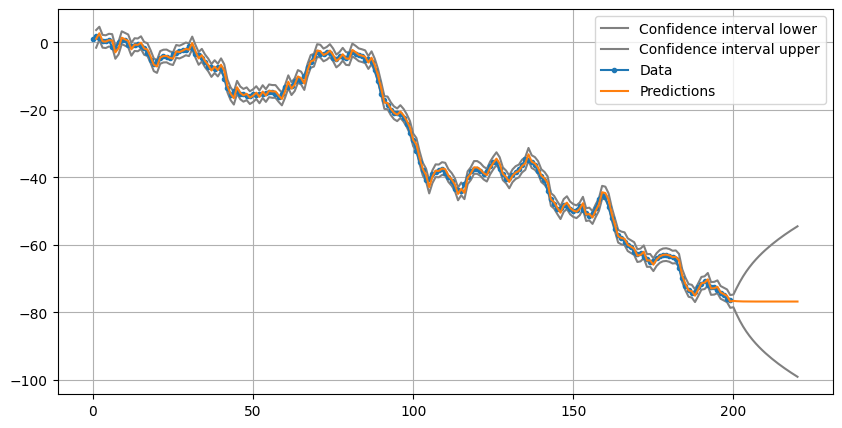

In [ ]:
preds = result_by_bic.get_prediction(start=1, end=220)
ci = preds.conf_int(alpha=0.05)

fig = ci.plot(label="Confidence interval", color="grey", figsize=(10, 5))
result_by_bic.data.orig_endog.plot(label="Data", marker=".", ax=fig)
preds.predicted_mean.plot(label="Predictions", ax=fig)

plt.legend(['Confidence interval lower','Confidence interval upper', 'Data', 'Predictions' ])
plt.grid(True)
plt.show()

The forecast's behavior is expected. In the short term, the ARIMA(1,1,1) prediction shows a curve as the AR and MA effects fade. Critically, with d=1, the long-run forecast simplifies into a straight line.

The confidence intervals also widen once training data is no longer available.